In [1]:
%load_ext autoreload
%autoreload 2
import cv2
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from models.dpt import DPT
from models.uformer import UformerSimple
from typing import List
from models.axialtransformer import AxialImageTransformer
from dataloaders.ColorizationDataset import ColorizationDataset
from dataloaders.HyperSim import HyperSimDataset, CrossEntropy2DLoss
from models.unet import UNet
from model import Uformer
from PIL import Image
import numpy as np
import pickle

In [9]:
train_set = ColorizationDataset(train=True)
train_set_256 = ColorizationDataset(train=True, width=256, height=256)
validation_set = ColorizationDataset(train=False, width=256, height=256)
print(len(train_set), len(validation_set))

# loss_fn = lambda pred, gt: torch.sum((pred - gt) ** 2, dim=1).mean()

5717 5823


In [3]:
seg_train_set = HyperSimDataset(train=True, width=256, height=256)
seg_val_set = HyperSimDataset(train=False, width=256, height=256)
print(len(seg_train_set), len(seg_val_set))

59543 7386


In [3]:
class CharbonnierLoss(nn.Module):
    """Charbonnier Loss (L1)"""

    def __init__(self, eps=1e-3):
        super(CharbonnierLoss, self).__init__()
        self.eps = eps

    def forward(self, x, y):
        diff = x - y
        # loss = torch.sum(torch.sqrt(diff * diff + self.eps))
        loss = torch.mean(torch.sqrt((diff * diff) + (self.eps*self.eps)))
        return loss
loss_fn = CharbonnierLoss()

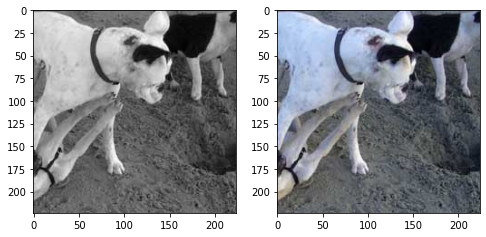

In [5]:
# Colorization example (DPT)
def show_image(idx: int):
    gray, color = train_set[idx]
    fig, ax = plt.subplots(1, 2, figsize=(8, 8))
    ax[0].imshow(gray.transpose((1, 2, 0)))
    ax[1].imshow(color.transpose((1, 2, 0)))
show_image(2)

In [4]:
def graph_stat(model_name: str, stats: List[str], max_epochs=150, smooth_size=1):
    plt.figure(facecolor='white', figsize=(12, 5))
    plt.title(f'{model_name} on {stats}')
    plt.xlabel('Epochs')
    with open(f'checkpoints/{model_name}/stats.pk', 'rb') as f:
        data = pickle.load(f)
    epochs = range(len(data[:max_epochs]))
    stat_values = {s:[] for s in stats }
    for d in data[:max_epochs]:
        for s in stats:
            stat_values[s].append(d[s])
    for s in stats:
        plt.plot(epochs, stat_values[s], label=s, alpha=0.6)
    plt.yscale('log')
    plt.xscale('log')
    plt.legend()

def get_stats(model_name: str, epoch: int):
    with open(f'checkpoints/{model_name}/stats.pk', 'rb') as f:
        data = pickle.load(f)
    return data[min(epoch, len(data) - 1)]

In [5]:
print('dpt', get_stats('color-dpt-base-new', 299))
print('uformer', get_stats('uformer-og-color_backup', -1))
print('axial', get_stats('axial-color', -1))
print('uformer 2', get_stats('uformer-color', 299))
print('unet', get_stats('unet-color', 299))

dpt {'epoch': 300, 'train_loss': 0.054190038358206516, 'eval_loss': 0.06959544202046734}
uformer {'epoch': 300, 'train_loss': 0.04364168871765492, 'eval_loss': 0.04590534553786351}
axial {'epoch': 258, 'train_loss': 0.040445872505292184, 'eval_loss': 0.04824515479308938}
uformer 2 {'epoch': 300, 'train_loss': 0.043237979882038556, 'eval_loss': 0.0464983112754423}
unet {'epoch': 300, 'train_loss': 0.033913062386619994, 'eval_loss': 0.048666860034436356}


In [6]:
print('dpt', get_stats('dpt-seg-2', 299))
print('uformer', get_stats('uformer-og-seg-2', -1))
print('axial', get_stats('axial-seg-2', -1))
print('uformer (simple)', get_stats('uformer-seg', 299))
print('unet', get_stats('unet-seg-2', 299))

dpt {'epoch': 40, 'train_loss': 0.3350747574431576, 'eval_loss': 3.5757731061324423, 'top1_accuracy': 0.36360257292641657}
uformer {'epoch': 32, 'train_loss': 0.3382389454519416, 'eval_loss': 2.0001707938715367, 'top1_accuracy': 0.46557534487393537}
axial {'epoch': 9, 'train_loss': 0.5221058836402743, 'eval_loss': 2.1119261148559065, 'top1_accuracy': 0.4095946782595151}
uformer (simple) {'epoch': 55, 'train_loss': 0.6980857930078669, 'eval_loss': 2.0238875544280903, 'top1_accuracy': 0.43168230810825026}
unet {'epoch': 127, 'train_loss': 0.1422747389805585, 'eval_loss': 3.3514008834555344, 'top1_accuracy': 0.45346367322309633}


tensor(0.0599)


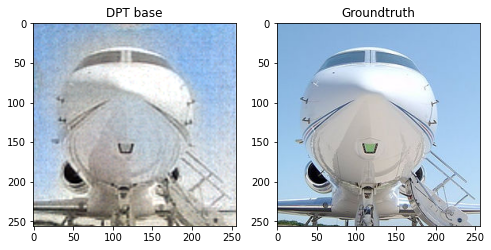

In [43]:
dpt_model = DPT(3).cuda()
dpt_model.load_state_dict(torch.load('checkpoints/color-dpt-base/model.pt'))
gray, color = validation_set[19]
pred = dpt_model(torch.tensor(gray).cuda().unsqueeze(0))[0].detach().cpu()
# pred = torch.sigmoid(pred)
print(loss_fn(pred, torch.tensor(color)))
fig, ax = plt.subplots(1, 2, figsize=(8, 8))
ax[0].set_title('DPT base')
ax[1].set_title('Groundtruth')
ax[0].imshow(torch.clamp(pred.permute(1, 2, 0), 0, 1))
ax[1].imshow(torch.tensor(color).permute(1, 2, 0))

In [51]:
pred_np = (torch.clamp(pred.permute(1, 2, 0), 0, 1).numpy() * 255).astype(np.uint8)
cv2.imwrite('colorization-uformer.png', cv2.cvtColor(pred_np, cv2.COLOR_RGB2BGR))
# target = (torch.tensor(color).permute(1, 2, 0).numpy() * 255).astype(np.uint8)
# cv2.imwrite('gt.png', cv2.cvtColor(target, cv2.COLOR_RGB2BGR))

True

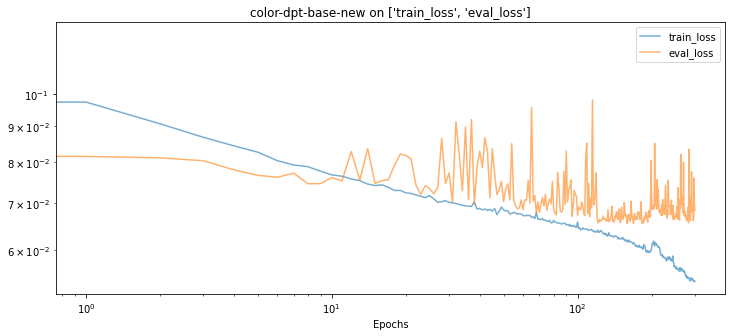

In [45]:
graph_stat('color-dpt-base-new', ['train_loss', 'eval_loss'], max_epochs=1000, smooth_size=5)

tensor(0.0594)


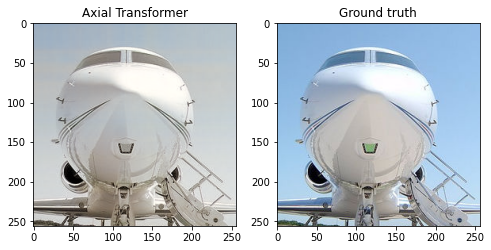

In [12]:
axial_model = AxialImageTransformer(dim=128, depth=8, heads=4, reversible=True).cuda()
axial_model.load_state_dict(torch.load('checkpoints/axial-color/model.pt'))
gray, color = validation_set[19]
pred = axial_model(torch.tensor(gray).cuda().unsqueeze(0))[0].detach().cpu()
print(loss_fn(pred, torch.tensor(color)))

fig, ax = plt.subplots(1, 2, figsize=(8, 8))
ax[0].set_title('Axial Transformer')
ax[1].set_title('Ground truth')
ax[0].imshow(torch.clamp(pred.permute(1, 2, 0), 0, 1))
ax[1].imshow(torch.tensor(color).permute(1, 2, 0))

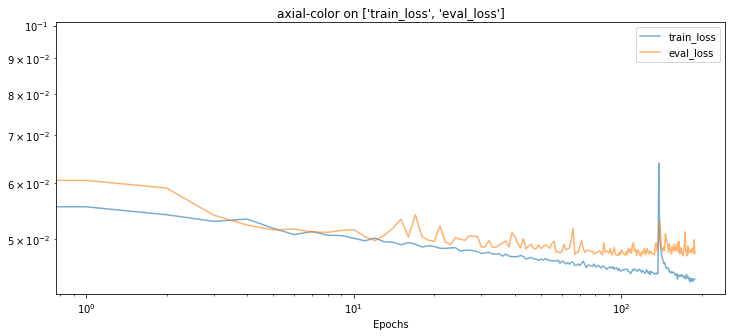

In [10]:
graph_stat('axial-color', ['train_loss', 'eval_loss'], max_epochs=1000, smooth_size=5)

tensor(0.2657)


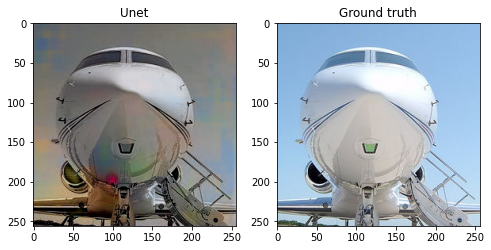

In [48]:
unet_model = UNet(n_channels=3, n_classes=3).cuda()
unet_model.load_state_dict(torch.load('checkpoints/unet-color/model.pt'))
gray, color = validation_set[19]
pred = unet_model(torch.tensor(gray).cuda().unsqueeze(0))[0].detach().cpu()
print(loss_fn(pred, torch.tensor(color)))

fig, ax = plt.subplots(1, 2, figsize=(8, 8))
ax[0].set_title('Unet')
ax[1].set_title('Ground truth')
ax[0].imshow(torch.clamp(pred.permute(1, 2, 0), 0, 1))
ax[1].imshow(torch.tensor(color).permute(1, 2, 0))

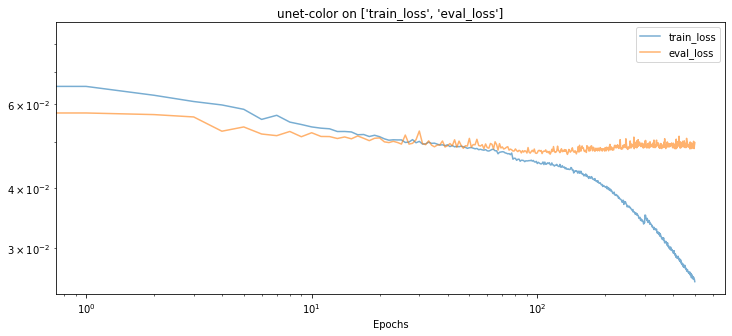

In [26]:
graph_stat('unet-color', ['train_loss', 'eval_loss'], max_epochs=1000, smooth_size=5)

tensor(0.0305)


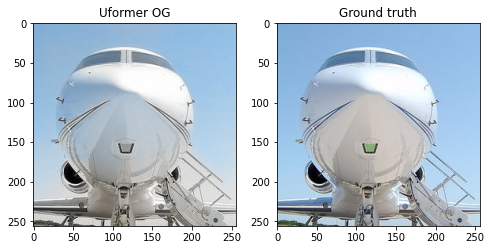

In [50]:
uformer_og_model = Uformer(256, out_channels=3).cuda()
uformer_og_model.load_state_dict(torch.load('checkpoints/uformer-og-color/model.pt'))
gray, color = validation_set[19]
pred = uformer_og_model(torch.tensor(gray).cuda().unsqueeze(0))[0].detach().cpu()
print(loss_fn(pred, torch.tensor(color)))

fig, ax = plt.subplots(1, 2, figsize=(8, 8))
ax[0].set_title('Uformer OG')
ax[1].set_title('Ground truth')
ax[0].imshow(torch.clamp(pred.permute(1, 2, 0), 0, 1))
ax[1].imshow(torch.tensor(color).permute(1, 2, 0))

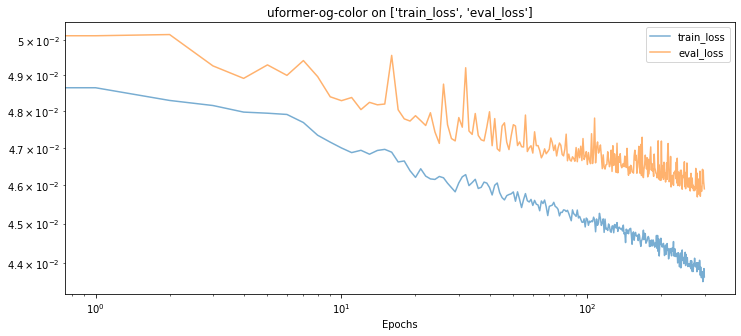

In [13]:
graph_stat('uformer-og-color', ['train_loss', 'eval_loss'], max_epochs=1000, smooth_size=5)

### Segmentation

In [53]:
def get_palette(n):
    palette = [0] * (n * 3)
    for j in range(0, n):
        lab = j
        palette[j * 3 + 0] = 0
        palette[j * 3 + 1] = 0
        palette[j * 3 + 2] = 0
        i = 0
        while lab:
            palette[j * 3 + 0] |= ((lab >> 0) & 1) << (7 - i)
            palette[j * 3 + 1] |= ((lab >> 1) & 1) << (7 - i)
            palette[j * 3 + 2] |= ((lab >> 2) & 1) << (7 - i)
            i += 1
            lab >>= 3
    return palette

palette = get_palette(40)

tensor(2.7653)
(256, 256) tensor(0.3244)


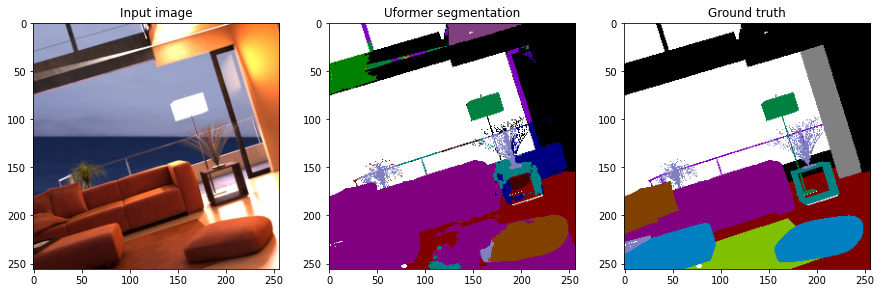

In [140]:
uformer_seg_model = Uformer(256, out_channels=40).cuda()
uformer_seg_model.load_state_dict(torch.load('checkpoints/uformer-og-seg-2/model.pt'))
img, label = seg_val_set[402]
pred = uformer_seg_model(torch.tensor(img).cuda().unsqueeze(0)).detach().cpu()
print(CrossEntropy2DLoss()(pred, torch.tensor(label).unsqueeze(0)))
pred = pred[0].argmax(dim=0).to(torch.uint8)
print(label.shape, (pred == torch.tensor(label)).float().mean())

pred_filtered = pred.numpy()
pred_filtered[label == -1] = -1
colored_pred = Image.fromarray(pred_filtered)
colored_pred.putpalette(palette)

colored_label = Image.fromarray(label.astype(np.uint8))
colored_label.putpalette(palette)

fig, ax = plt.subplots(1, 3, figsize=(15, 8))
ax[0].set_title('Input image')
ax[1].set_title('Uformer segmentation')
ax[2].set_title('Ground truth')
ax[0].imshow(img.transpose((1, 2, 0)))
ax[1].imshow(colored_pred)
ax[2].imshow(colored_label)

In [122]:
cv2.imwrite('seg-input.png', cv2.cvtColor(img.transpose((1, 2, 0)) * 255, cv2.COLOR_RGB2BGR))

True

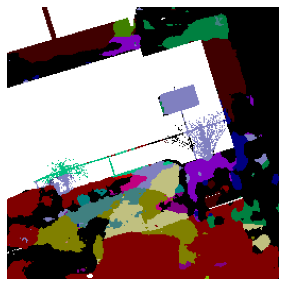

In [135]:
plt.figure(figsize=(5,5))
plt.axis('off')
plt.imshow(colored_pred)
plt.savefig('seg-dpt.png', dpi=100)

In [110]:
cv2.imwrite('uformer-seg.png', np.array(colored_pred))

True

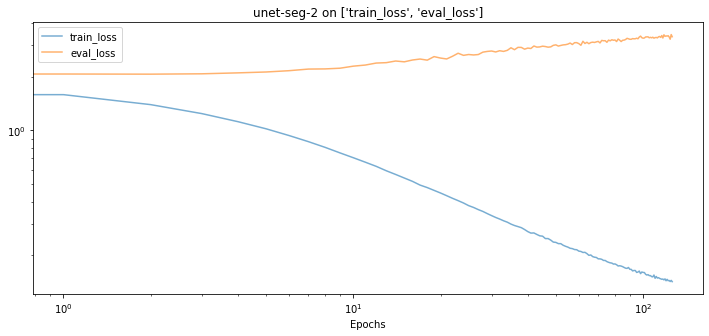

In [7]:
graph_stat('unet-seg-2', ['train_loss', 'eval_loss'], max_epochs=1000, smooth_size=5)

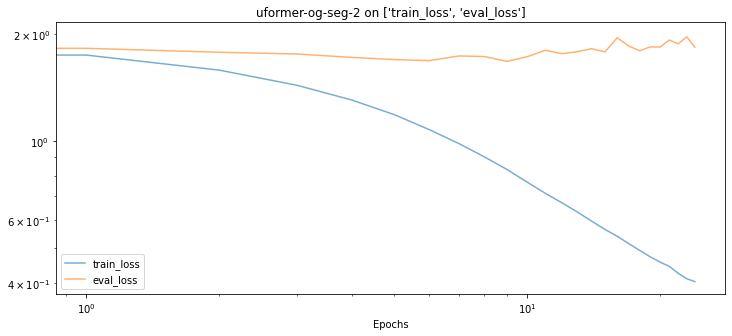

In [25]:
graph_stat('uformer-og-seg-2', ['train_loss', 'eval_loss'], max_epochs=1000, smooth_size=5)

tensor(0.2191)
(256, 256) tensor(0.9217)


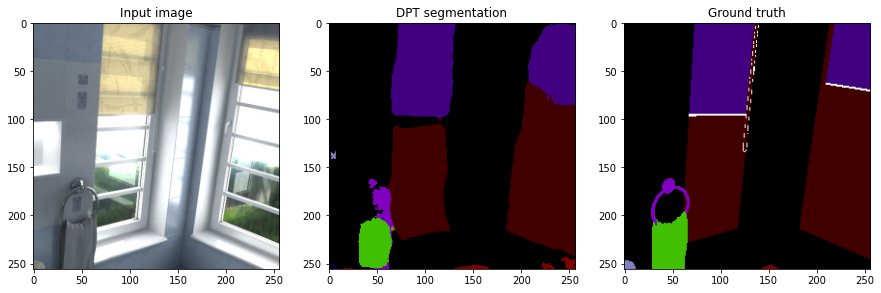

In [23]:
dpt_seg_model = DPT(40).cuda()
dpt_seg_model.load_state_dict(torch.load('checkpoints/dpt-seg-2/model.pt'))
img, label = seg_train_set[1]
pred = dpt_seg_model(torch.tensor(img).cuda().unsqueeze(0)).detach().cpu()
print(CrossEntropy2DLoss()(pred, torch.tensor(label).unsqueeze(0)))
pred = pred[0].argmax(dim=0).to(torch.uint8)
print(label.shape, (pred == torch.tensor(label)).float().mean())

colored_pred = Image.fromarray(pred.numpy())
colored_pred.putpalette(palette)

colored_label = Image.fromarray(label.astype(np.uint8))
colored_label.putpalette(palette)

fig, ax = plt.subplots(1, 3, figsize=(15, 8))
ax[0].set_title('Input image')
ax[1].set_title('DPT segmentation')
ax[2].set_title('Ground truth')
ax[0].imshow(img.transpose((1, 2, 0)))
ax[1].imshow(colored_pred)
ax[2].imshow(colored_label)

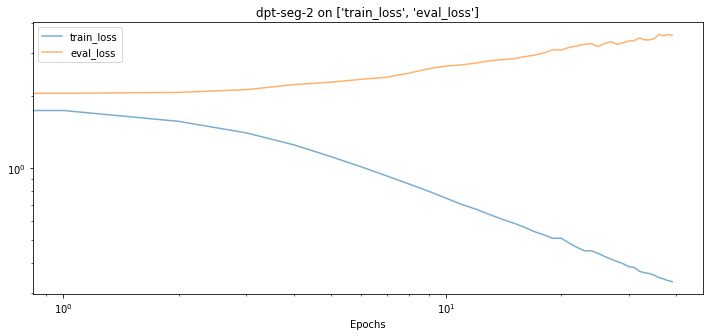

In [19]:
graph_stat('dpt-seg-2', ['train_loss', 'eval_loss'], max_epochs=1000, smooth_size=5)

In [15]:
window_size = 4
coords_h = torch.arange(window_size) # [0,...,Wh-1]
coords_w = torch.arange(window_size) # [0,...,Ww-1]
coords = torch.stack(torch.meshgrid([coords_h, coords_w]))
coords_flatten = torch.flatten(coords, 1)
coords_flatten

tensor([[0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3],
        [0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3]])

In [16]:
bias_table = torch.arange((2 * window_size - 1) ** 2).unsqueeze(-1)
relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
print(relative_coords.shape)
relative_coords[:, :, 0] += window_size - 1  # shift to start from 0
relative_coords[:, :, 1] += window_size - 1
relative_coords[:, :, 0] *= 2 * window_size - 1
relative_position_index = relative_coords.sum(-1)
relative_coords.shape, relative_position_index.shape, torch.max(relative_position_index)

torch.Size([16, 16, 2])


(torch.Size([16, 16, 2]), torch.Size([16, 16]), tensor(48))

In [20]:
relative_position_bias = bias_table[relative_position_index.view(-1)].view(window_size ** 2, window_size ** 2, -1)
relative_position_bias = relative_position_bias.permute(2, 0, 1)
ratio = window_size ** 2 //relative_position_bias.size(-1)
print(relative_position_bias.shape)
relative_position_bias
# relative_position_bias = einops.repeat(relative_position_bias, 'nH l c -> nH l (c d)', d = ratio)
# print(relative_position_bias.shape, ratio)
relative_position_bias.shape, ratio

torch.Size([1, 16, 16])


(torch.Size([1, 16, 16]), 1)

In [16]:
print('dpt params:', sum(p.numel() for p in dpt_model.parameters()))
print('uformer params:', sum(p.numel() for p in uformer_model.parameters()))
print('axial params:', sum(p.numel() for p in axial_model.parameters()))

dpt params: 112501422
uformer params: 4579843
axial params: 19944323


In [29]:
sum(p.numel() for p in unet_model.parameters())

31037763

In [30]:
sum(p.numel() for p in uformer_og_model.parameters())

20628317

In [34]:
sum(p.numel() for p in uformer_seg_model.parameters())

20649666

In [33]:
sum(p.numel() for p in axial_model.parameters())

19944323

In [8]:
ax_seg = AxialImageTransformer(dim=128, depth=8, heads=4, output_channels=40, reversible=True)
sum(p.numel() for p in ax_seg.parameters())

19990056

In [9]:
unet_seg = UNet(n_channels=3, n_classes=40)
sum(p.numel() for p in unet_seg.parameters())

31040168

In [10]:
dpt_seg = DPT(40)
sum(p.numel() for p in dpt_seg.parameters())

112520440